## Machhine Learning for data science salaries

> With a good amount of EDA and data wrangling that have gone ahead of this  dataset, we will proceed to the ML stage and given that we do not a have a numerical feature in the independent Features for predicting the dependent Feature, we will be using a DecisionTreeRegressor or an ensemble model.

> Let us go ahead with importing certain important libraries that would be used

In [189]:
from IPython.display import display

In [178]:
#Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from ipywidgets import interact, Dropdown, FloatSlider, IntSlider

In [6]:
#Load dataset

df = pd.read_csv("ds_clean.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,employee_residence_iso,company_location_iso
0,2020-01-01,Mid-level,Full Time,Data Scientist,79833,Germany,<20% Remote,Germany,Large,DEU,DEU
1,2020-01-01,Senior-level,Full Time,Machine Learning,260000,Japan,<20% Remote,Japan,Small,JPN,JPN
2,2020-01-01,Senior-level,Full Time,Data Engineer,109024,United Kingdom,Partial Remote,United Kingdom,Medium,GBR,GBR
3,2020-01-01,Mid-level,Full Time,Data Analyst,20000,Honduras,<20% Remote,Honduras,Small,HND,HND
4,2020-01-01,Senior-level,Full Time,Machine Learning,150000,United States,Partial Remote,United States,Large,USA,USA


In [7]:
#Do a general data inspection

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   work_year               605 non-null    object
 1   experience_level        605 non-null    object
 2   employment_type         605 non-null    object
 3   job_title               605 non-null    object
 4   salary_in_usd           605 non-null    int64 
 5   employee_residence      605 non-null    object
 6   remote_ratio            605 non-null    object
 7   company_location        605 non-null    object
 8   company_size            605 non-null    object
 9   employee_residence_iso  605 non-null    object
 10  company_location_iso    605 non-null    object
dtypes: int64(1), object(10)
memory usage: 52.1+ KB


Since we would be using a decision tree or an ensemble model of such, using ordinal encoding would not be a problem regardless of the natural object of such objects.

In [9]:
#Drop duplicate columns that do the same thing (employee_residence_iso and comapny_location_iso)

df.drop(columns = ["employee_residence_iso", "company_location_iso"], inplace = True)

In [10]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020-01-01,Mid-level,Full Time,Data Scientist,79833,Germany,<20% Remote,Germany,Large
1,2020-01-01,Senior-level,Full Time,Machine Learning,260000,Japan,<20% Remote,Japan,Small
2,2020-01-01,Senior-level,Full Time,Data Engineer,109024,United Kingdom,Partial Remote,United Kingdom,Medium
3,2020-01-01,Mid-level,Full Time,Data Analyst,20000,Honduras,<20% Remote,Honduras,Small
4,2020-01-01,Senior-level,Full Time,Machine Learning,150000,United States,Partial Remote,United States,Large


In [14]:
df.work_year.unique()

array(['2020-01-01', '2021-01-01', '2022-01-01'], dtype=object)

In [16]:
#Replace the year column for more meaningful labeling
df["work_year"] = df.work_year.str[0:4]
df["work_year"].head()

0    2020
1    2020
2    2020
3    2020
4    2020
Name: work_year, dtype: object

In [18]:
#Check for high cardinality or low cardinality features

df.drop(columns = "salary_in_usd").nunique()

work_year              3
experience_level       4
employment_type        4
job_title              7
employee_residence    57
remote_ratio           3
company_location      50
company_size           3
dtype: int64

We should drop the employe_residence, as it might interfere with the model while we know that most of the time an employee residence is usually very related with the company location.

In [21]:
df.drop(columns = "employee_residence", inplace = True)

In [35]:
#Adressing the cardinality of company_location, reduce companies that have less than 11 counts to others
company_11 = df["company_location"].value_counts().head(8).index
company_11

def reduce_cardinality(row):
    
    """Function Reduces
    the cardinality of company location"""
    if row in company_11:
        return row
    else:
        return "Others"
    pass

df["company_location"] = df["company_location"].apply(reduce_cardinality)
df["company_location"].value_counts()

United States     353
Others             83
United Kingdom     47
Canada             30
Germany            28
India              24
France             15
Spain              14
Greece             11
Name: company_location, dtype: int64

In [36]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,Mid-level,Full Time,Data Scientist,79833,<20% Remote,Germany,Large
1,2020,Senior-level,Full Time,Machine Learning,260000,<20% Remote,Others,Small
2,2020,Senior-level,Full Time,Data Engineer,109024,Partial Remote,United Kingdom,Medium
3,2020,Mid-level,Full Time,Data Analyst,20000,<20% Remote,Others,Small
4,2020,Senior-level,Full Time,Machine Learning,150000,Partial Remote,United States,Large


### Split dataset

In [37]:
#Split into Feature and target
target = "salary_in_usd"
y = df[target]
X = df.drop(columns = target)

print(f"shape of X is {X.shape}")
print(f"shape of y is {y.shape}")

shape of X is (605, 7)
shape of y is (605,)


In [39]:
#Split into train and test samples

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

print(f"shape of X_train is {X_train.shape}")
print(f"shape of X_test is {X_test.shape}")
print(f"shape of y_train is {y_train.shape}")
print(f"shape of y_test is {y_test.shape}")

shape of X_train is (484, 7)
shape of X_test is (121, 7)
shape of y_train is (484,)
shape of y_test is (121,)


### Define Baseline

In [63]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
y_pred_mae = mean_absolute_error(y_train, y_pred_baseline)
print(f"The baseline mean absolute error for the naive model is {y_pred_mae.round(2)}")

The baseline mean absolute error for the naive model is 52195.07


### Iterate and Build model

In [58]:
#Define model pipeline

pipeline = make_pipeline(OrdinalEncoder(),
                        DecisionTreeRegressor(criterion = "squared_error"))

In [78]:
#Use hyperparameter tuning
params = {"decisiontreeregressor__max_depth": range(50, 150, 15),
         "decisiontreeregressor__min_samples_split": range(2, 60, 2) }

model = GridSearchCV(pipeline,
                     param_grid=params,
                     n_jobs = -1,
                     cv = 5,
                     verbose = 1)

model.fit(X_train, y_train)

Fitting 5 folds for each of 203 candidates, totalling 1015 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': range(50, 150, 15),
                         'decisiontreeregressor__min_samples_split': range(2, 60, 2)},
             verbose=1)

In [83]:
pd.DataFrame(model.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
165,0.081024,0.004710,0.026658,0.001666,125,42,"{'decisiontreeregressor__max_depth': 125, 'dec...",0.400514,0.53371,0.225568,0.523926,0.320381,0.40082,0.11832,1
136,0.082749,0.005266,0.030381,0.003260,110,42,"{'decisiontreeregressor__max_depth': 110, 'dec...",0.400514,0.53371,0.225568,0.523926,0.320381,0.40082,0.11832,1
107,0.086376,0.008168,0.027935,0.002159,95,42,"{'decisiontreeregressor__max_depth': 95, 'deci...",0.400514,0.53371,0.225568,0.523926,0.320381,0.40082,0.11832,1
49,0.078725,0.007141,0.029353,0.004266,65,42,"{'decisiontreeregressor__max_depth': 65, 'deci...",0.400514,0.53371,0.225568,0.523926,0.320381,0.40082,0.11832,1
20,0.091071,0.008737,0.028255,0.004539,50,42,"{'decisiontreeregressor__max_depth': 50, 'deci...",0.400514,0.53371,0.225568,0.523926,0.320381,0.40082,0.11832,1


We beat the baseline score. Let us check the best parameters and check the mean absolute error of the model.

In [84]:
model.best_params_

{'decisiontreeregressor__max_depth': 50,
 'decisiontreeregressor__min_samples_split': 42}

In [91]:
y_pred = model.predict(X_train)
print(f"The mean absolut error of model obtained is {mean_absolute_error(y_train, y_pred).round(2)}")

The mean absolut error of model obtained is 33283.06


The model can be iterated further and using ensemble models like `RandomForestRegressors` or `GradientBoostinRegressors`.

In [94]:
#Iterate with Test set.
mean_absolute_error(y_test, model.predict(X_test))

36227.740037876196

### Communicating the result

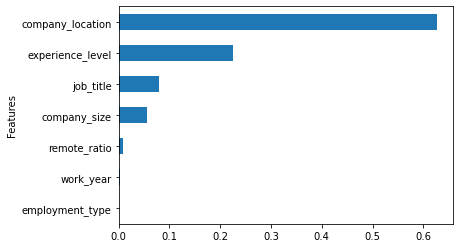

In [101]:
#Feature Importance
importances = model.best_estimator_.named_steps["decisiontreeregressor"].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.plot(kind = "barh",
             ylabel = "Importance",
             xlabel = "Features");

From the above plot, we do see that company location and experience level play a hige role in splitting of the decision tree.

A quick EDA on how the company location can affect the salary of a data scientist.

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

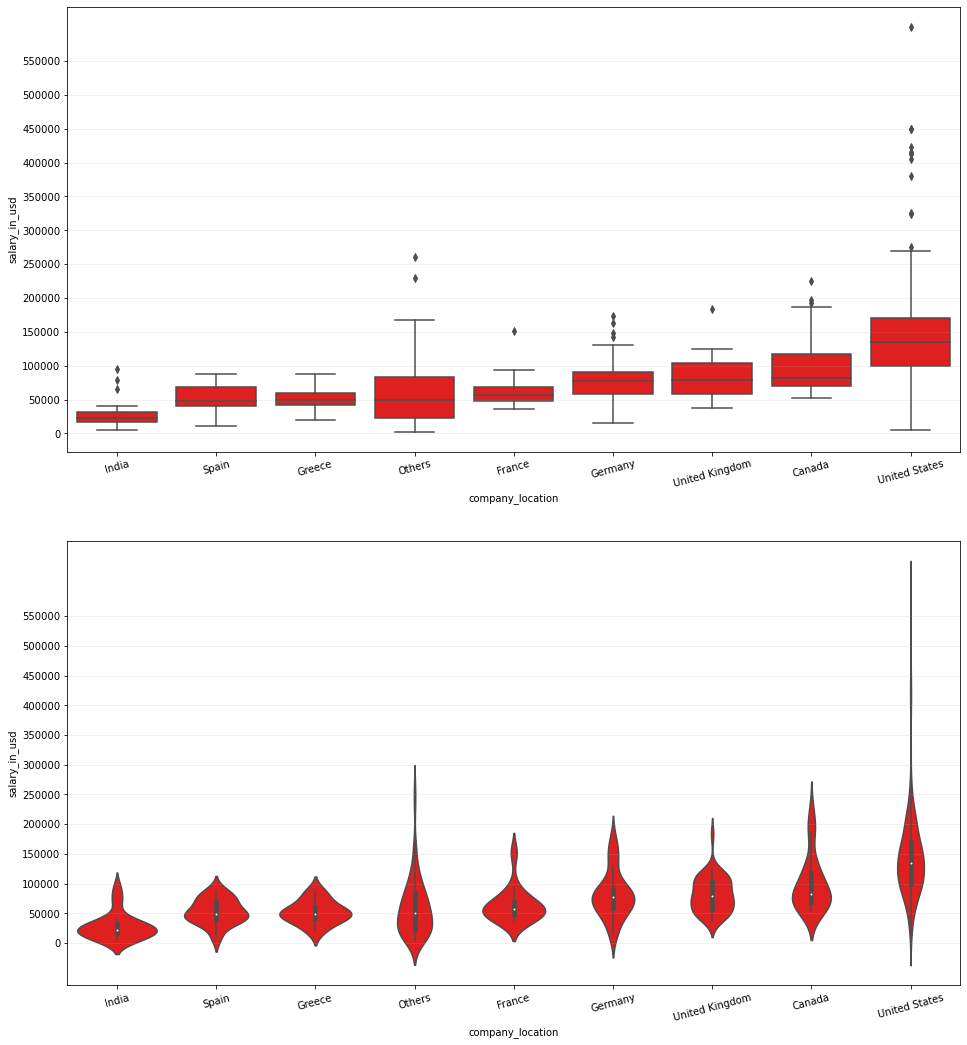

In [118]:
order = df.groupby("company_location")["salary_in_usd"].median().sort_values().index

plt.figure(figsize = [16, 18])
plt.subplot(2, 1, 1)
sns.boxplot(data = df, x = "company_location", y = "salary_in_usd", color = "r", order = order)
y_ticks = np.arange(0, 600000, 50000)
plt.yticks(y_ticks, y_ticks)
plt.xticks(rotation = 15)
plt.grid(axis = "y", alpha = 0.2)

plt.subplot(2, 1, 2)
sns.violinplot(data = df, x = "company_location", y = "salary_in_usd", color = "r", order = order)
y_ticks = np.arange(0, 600000, 50000)
plt.yticks(y_ticks, y_ticks)
plt.xticks(rotation = 15)
plt.grid(axis = "y", alpha = 0.2);

From the plot above, it is apparent that the top 5 companies that have highly paid data science jobs are in the United States, Canada, United Kingdom, Germany and France.

In [141]:
country_df =df.groupby("company_location")["salary_in_usd"].mean().sort_values().to_frame()
country_df.rename(columns = {"salary_in_usd": "Mean salary[USD]"}).style.background_gradient(cmap = "Reds")

,Mean salary[USD]
company_location,
India,28581.750000
Greece,52293.090909
Spain,53060.142857
Others,59513.783133
France,63970.666667
United Kingdom,81583.042553
Germany,81887.214286
Canada,99823.733333
United States,143525.830028


The United States with a mean salary for data scientist of `143,525` USD takes the lead

### Define Function and make Interactive widgets. 

In [ ]:
less than 50 employees (small)
M = 50 to 250 employees (medium)
L = more than 250 employees (large)

In [155]:
y_train.head(2)

235     46809
9      125000
Name: salary_in_usd, dtype: int64

In [142]:
X_train.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [162]:
def make_prediction(year, experience, employment_type, job_title, remote_ratio, 
                    company_location, company_size_upper_bound):
    
    """Function that takes in values of Features
    and return the model predicted value of salary"""
    
    if company_size_upper_bound <  50:
        company_size = "Small"
        pass
    elif company_size_upper_bound < 250:
        company_size = "Medium"
        pass
    else:
        company_size = "Large"
        pass
    pd_dict = {"work_year": year,
              "experience_level": experience,
              "employment_type": employment_type,
              "job_title": job_title,
              "remote_ratio": remote_ratio,
              "company_location": company_location,
              "company_size": company_size}
    X_t = pd.DataFrame(pd_dict, index = [0])
    return model.predict(X_t)[0].round(2)

In [154]:
make_prediction("2020", "Mid-level", "Full Time", "Data Scientist", ">80% Remote", "Spain", 220)

51727.73

In [171]:
X_train["work_year"].unique()

array(['2021', '2020', '2022'], dtype=object)

In [191]:
#Create Interactive plot

interact = interact(
    make_prediction,
    company_size_upper_bound = IntSlider(min = 10, max = 100_000, step = 5),
    year = Dropdown(options = sorted(X_train["work_year"].unique())),
    experience = Dropdown(options = sorted(X_train["experience_level"].unique())),
    employment_type = Dropdown(options = sorted(X_train["employment_type"].unique())),
    job_title = Dropdown(options = sorted(X_train["job_title"].unique())),
    remote_ratio = Dropdown(options = sorted(X_train["remote_ratio"].unique())),
    company_location = Dropdown(options = sorted(X_train["company_location"].unique())),

);

92041.2

In [192]:
display(interact)

<function __main__.make_prediction(year, experience, employment_type, job_title, remote_ratio, company_location, company_size_upper_bound)>

In [168]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);